# Exploring Convolutional Layers Through Data and Experiments

**Dataset:** Fashion-MNIST

**Experiment Focus:** Kernel Size Comparison (3×3 vs 5×5)

---

## Table of Contents
1. [Dataset Exploration (EDA)](#1-dataset-exploration)
2. [Baseline Model (Non-Convolutional)](#2-baseline-model)
3. [Convolutional Architecture Design](#3-convolutional-architecture)
4. [Controlled Experiments](#4-controlled-experiments)
5. [Interpretation and Reasoning](#5-interpretation)
6. [SageMaker Deployment](#6-sagemaker-deployment)

## Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


---
## 1. Dataset Exploration (EDA)

### 1.1 Dataset Selection Justification

**Why Fashion-MNIST is appropriate for convolutional layers:**

Fashion-MNIST consists of grayscale images of clothing items, where:
- **Spatial structure matters**: Clothing items have recognizable shapes and textures that are spatially organized
- **Translation invariance**: A shirt is a shirt regardless of its exact position in the image
- **Local patterns**: Features like collars, sleeves, and patterns are localized and can be detected with small kernels
- **Hierarchical features**: Low-level edges combine into mid-level textures, which form high-level garment shapes

This makes it ideal for demonstrating how convolutional layers exploit spatial structure through shared weights and local receptive fields.

### 1.2 Load Dataset

In [ ]:
# Load Fashion-MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Pixel value range: [{X_train.min()}, {X_train.max()}]")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)

Number of classes: 10
Pixel value range: [0, 255]


### 1.3 Class Distribution

         Class  Train  Test
0  T-shirt/top   6000  1000
1      Trouser   6000  1000
2     Pullover   6000  1000
3        Dress   6000  1000
4         Coat   6000  1000
5       Sandal   6000  1000
6        Shirt   6000  1000
7      Sneaker   6000  1000
8          Bag   6000  1000
9   Ankle boot   6000  1000

Dataset is balanced: True


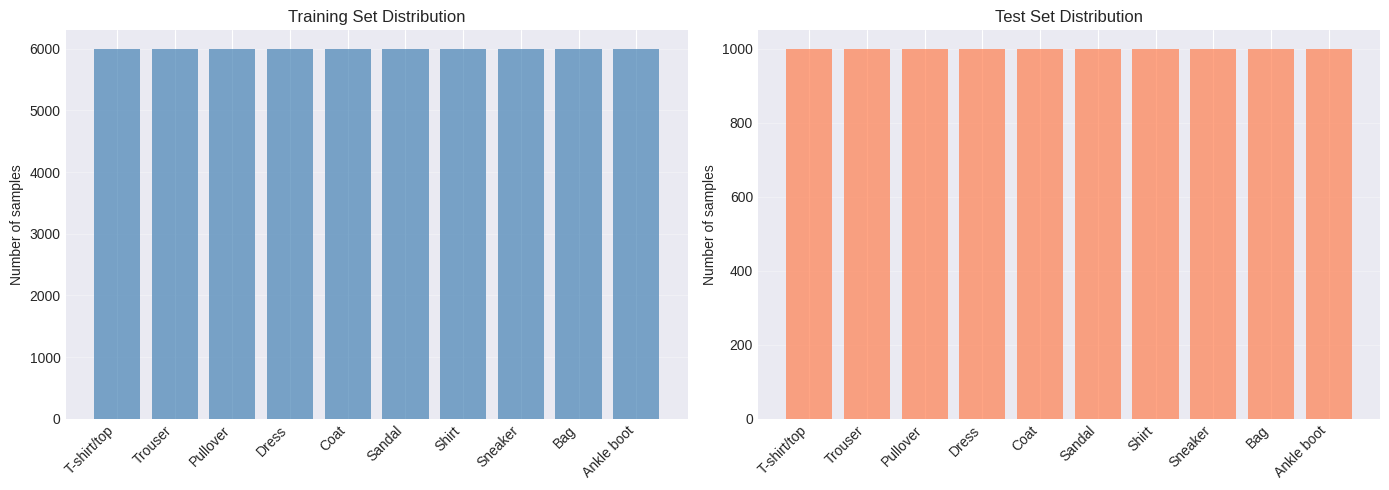

In [ ]:
# Count samples per class
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Create distribution dataframe
dist_df = pd.DataFrame({
    'Class': class_names,
    'Train': [train_counts[i] for i in range(10)],
    'Test': [test_counts[i] for i in range(10)]
})

print(dist_df)
print(f"\nDataset is balanced: {len(set(train_counts.values())) == 1}")

# Visualize distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), [train_counts[i] for i in range(10)], color='steelblue', alpha=0.7)
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(class_names, rotation=45, ha='right')
ax[0].set_ylabel('Number of samples')
ax[0].set_title('Training Set Distribution')
ax[0].grid(axis='y', alpha=0.3)

ax[1].bar(range(10), [test_counts[i] for i in range(10)], color='coral', alpha=0.7)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(class_names, rotation=45, ha='right')
ax[1].set_ylabel('Number of samples')
ax[1].set_title('Test Set Distribution')
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 1.4 Sample Visualization

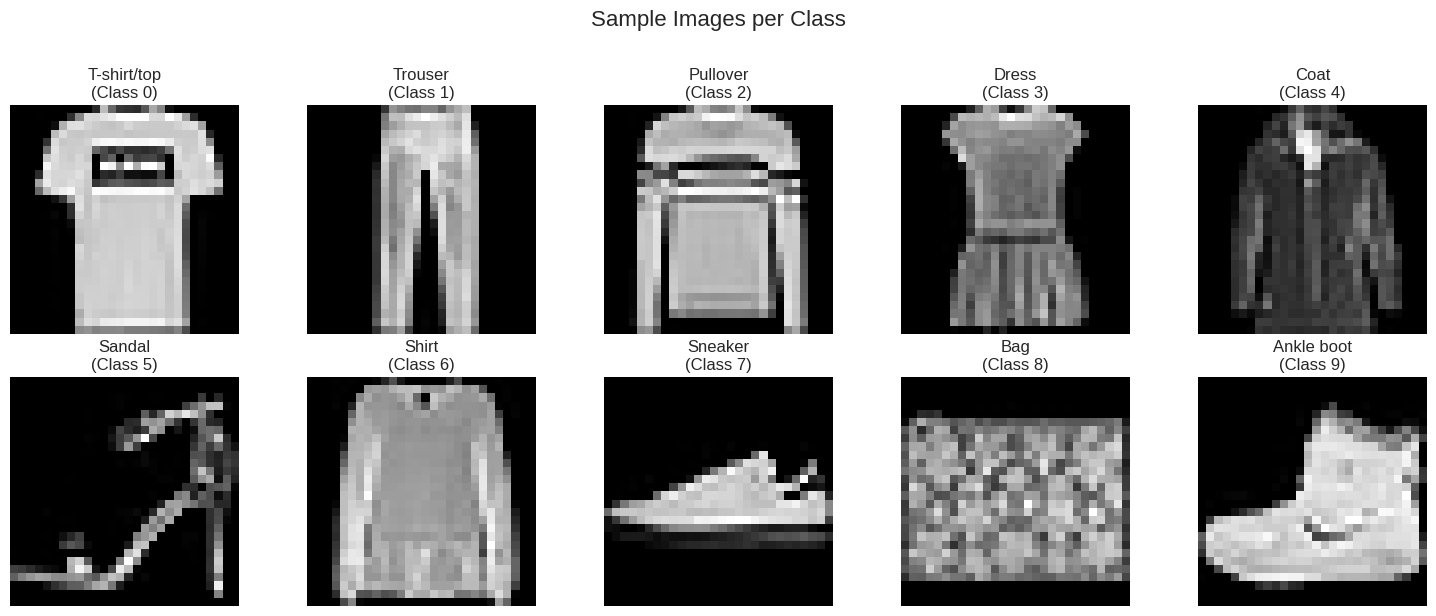

In [ ]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    # Find first occurrence of each class
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[idx], cmap='gray')
    axes[i].set_title(f'{class_names[i]}\n(Class {i})')
    axes[i].axis('off')

plt.suptitle('Sample Images per Class', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 1.5 Image Statistics and Preprocessing

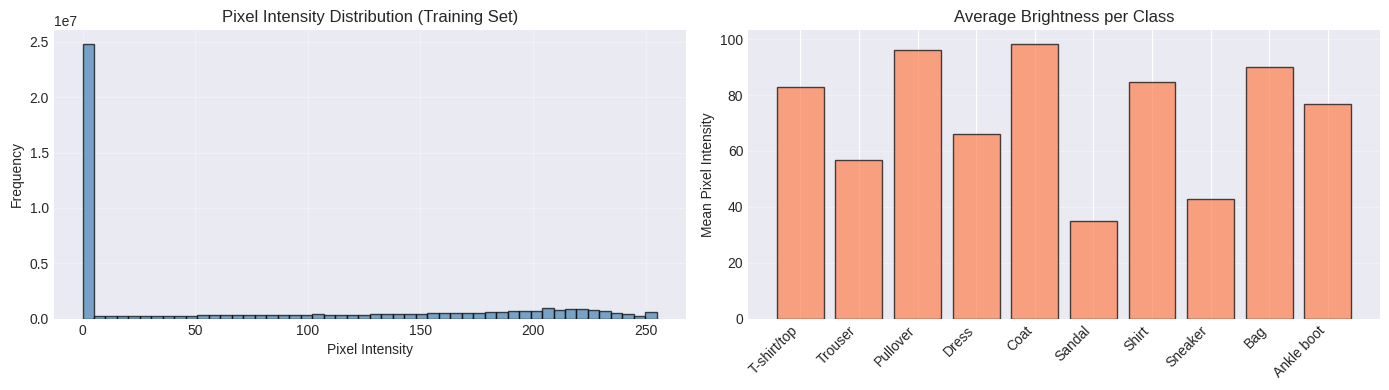

Overall mean pixel value: 72.94
Overall std pixel value: 90.02


In [ ]:
# Analyze pixel intensity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Overall pixel distribution
axes[0].hist(X_train.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pixel Intensity Distribution (Training Set)')
axes[0].grid(alpha=0.3)

# Mean pixel value per class
mean_intensities = [X_train[y_train == i].mean() for i in range(10)]
axes[1].bar(range(10), mean_intensities, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(10))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_ylabel('Mean Pixel Intensity')
axes[1].set_title('Average Brightness per Class')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Overall mean pixel value: {X_train.mean():.2f}")
print(f"Overall std pixel value: {X_train.std():.2f}")

### 1.6 Data Preprocessing

In [ ]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# For CNN: reshape to add channel dimension (28, 28, 1)
X_train_cnn = X_train_normalized.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_normalized.reshape(-1, 28, 28, 1)

# For baseline (fully connected): flatten to 1D vector
X_train_flat = X_train_normalized.reshape(-1, 28*28)
X_test_flat = X_test_normalized.reshape(-1, 28*28)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Preprocessed shapes:")
print(f"CNN input: {X_train_cnn.shape}")
print(f"Flattened input: {X_train_flat.shape}")
print(f"Labels (one-hot): {y_train_cat.shape}")

Preprocessed shapes:
CNN input: (60000, 28, 28, 1)
Flattened input: (60000, 784)
Labels (one-hot): (60000, 10)


---
## 2. Baseline Model (Non-Convolutional)

### 2.1 Architecture Definition

The baseline model uses only fully connected (Dense) layers:
- **Input**: Flattened 784-dimensional vector (28×28)
- **Hidden layers**: Two dense layers with ReLU activation
- **Output**: 10-class softmax

This architecture ignores spatial structure and treats all pixels equally.

In [ ]:
def create_baseline_model():
    """
    Fully connected baseline network.
    No convolutional layers - treats input as flat vector.
    """
    model = models.Sequential([
        layers.Input(shape=(784,)),

        # First dense layer
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.2),

        # Second dense layer
        layers.Dense(64, activation='relu', name='dense2'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(10, activation='softmax', name='output')
    ], name='Baseline_FC')

    return model

baseline_model = create_baseline_model()
baseline_model.summary()

print(f"\nTotal parameters: {baseline_model.count_params():,}")

Model: "Baseline_FC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense1 (Dense)                  │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 109,386


### 2.2 Model Training

In [ ]:
# Compile model
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_baseline = baseline_model.fit(
    X_train_flat, y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    verbose=1
)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6653 - loss: 0.9513 - val_accuracy: 0.8448 - val_loss: 0.4242
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8341 - loss: 0.4727 - val_accuracy: 0.8582 - val_loss: 0.3775
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8535 - loss: 0.4153 - val_accuracy: 0.8662 - val_loss: 0.3618
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8637 - loss: 0.3834 - val_accuracy: 0.8717 - val_loss: 0.3532
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8712 - loss: 0.3590 - val_accuracy: 0.8692 - val_loss: 0.3545
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8738 - loss: 0.3474 - val_accuracy: 0.8772 - val_loss: 0.3361
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8767 - loss: 0.3367 - val_accuracy: 0.8807 - val_loss: 0.3381
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8822 - loss: 0.3220 - val_accuracy: 0.

### 2.3 Baseline Results

Baseline Model Performance:
Test Accuracy: 88.32%
Test Loss: 0.3372


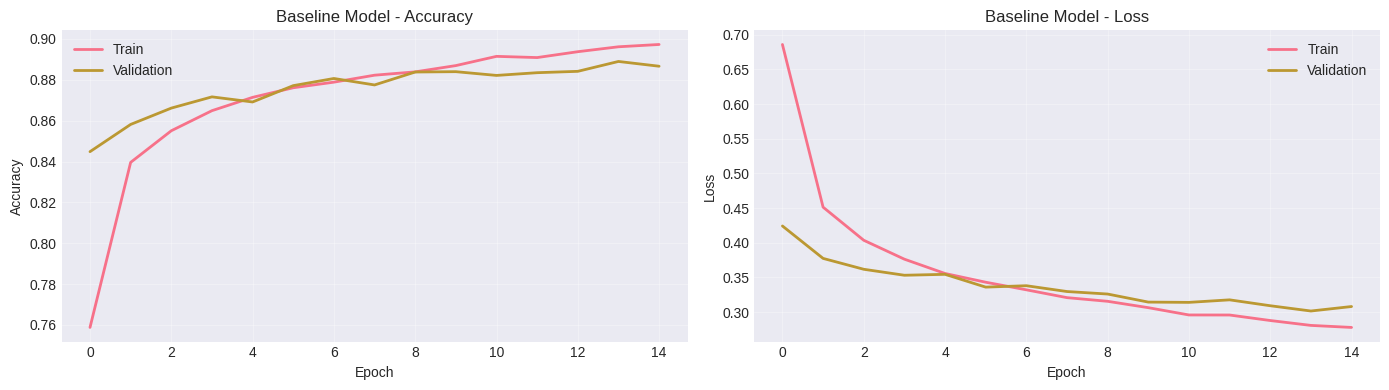

In [ ]:
# Evaluate on test set
baseline_loss, baseline_acc = baseline_model.evaluate(X_test_flat, y_test_cat, verbose=0)

print(f"Baseline Model Performance:")
print(f"Test Accuracy: {baseline_acc*100:.2f}%")
print(f"Test Loss: {baseline_loss:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy
axes[0].plot(history_baseline.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_baseline.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Baseline Model - Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_baseline.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_baseline.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Baseline Model - Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.4 Observed Limitations

**Key limitations of the fully connected baseline:**

1. **Ignores spatial structure**: Flattening destroys the 2D relationships between pixels
2. **No translation invariance**: A pattern must be learned separately for each position
3. **Parameter explosion**: Every pixel connects to every neuron (784 × 128 = 100,352 weights in first layer alone)
4. **No hierarchical learning**: Cannot build complex features from simpler ones
5. **Overfitting risk**: Large parameter count relative to training samples

---
## 3. Convolutional Architecture Design

### 3.1 Architecture Rationale

**Design principles:**

1. **Small kernels (3×3)**: Capture local patterns efficiently while allowing deep networks
2. **Progressive channel growth**: 32 → 64 → 128 filters to learn increasingly complex features
3. **Max pooling**: Downsample spatial dimensions for translation invariance and computational efficiency
4. **Moderate depth**: 3 convolutional blocks balance expressiveness with training stability
5. **ReLU activation**: Standard choice for non-linearity in CNNs

**Architecture:**
```
Input (28×28×1)
    ↓
Conv2D(32, 3×3) + ReLU → (28×28×32)
MaxPool(2×2) → (14×14×32)
    ↓
Conv2D(64, 3×3) + ReLU → (14×14×64)
MaxPool(2×2) → (7×7×64)
    ↓
Conv2D(128, 3×3) + ReLU → (7×7×128)
MaxPool(2×2) → (3×3×128)
    ↓
Flatten → (1152)
    ↓
Dense(128) + ReLU + Dropout
    ↓
Dense(10) + Softmax
```

In [ ]:
def create_cnn_model(kernel_size=3, name='CNN'):
    """
    Convolutional neural network for Fashion-MNIST.

    Args:
        kernel_size: Size of convolutional kernels (3 or 5)
        name: Model name for identification
    """
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        # First convolutional block
        layers.Conv2D(32, (kernel_size, kernel_size),
                     activation='relu',
                     padding='same',
                     name=f'conv1_{kernel_size}x{kernel_size}'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second convolutional block
        layers.Conv2D(64, (kernel_size, kernel_size),
                     activation='relu',
                     padding='same',
                     name=f'conv2_{kernel_size}x{kernel_size}'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Third convolutional block
        layers.Conv2D(128, (kernel_size, kernel_size),
                     activation='relu',
                     padding='same',
                     name=f'conv3_{kernel_size}x{kernel_size}'),
        layers.MaxPooling2D((2, 2), name='pool3'),

        # Dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(10, activation='softmax', name='output')
    ], name=name)

    return model

# Create and display model with 3x3 kernels
cnn_3x3 = create_cnn_model(kernel_size=3, name='CNN_3x3')
cnn_3x3.summary()

print(f"\nTotal parameters: {cnn_3x3.count_params():,}")

Model: "CNN_3x3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_3x3 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3x3 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3x3 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 241,546


### 3.2 Architectural Justifications

**Padding = 'same':**
- Preserves spatial dimensions after convolution
- Allows information at image borders to be processed equally
- More stable training with multiple layers

**MaxPooling 2×2:**
- Reduces spatial dimensions by half
- Provides translation invariance
- Reduces computational cost
- Acts as mild regularization

**Progressive filter increase (32→64→128):**
- Early layers learn simple features (edges, textures)
- Later layers combine these into complex patterns
- Matches the hierarchical nature of visual information

**Dropout (0.3):**
- Prevents overfitting on the dense layer
- Not used in conv layers as they already have strong regularization through weight sharing

---
## 4. Controlled Experiments on Kernel Size

### 4.1 Experiment Design

**Research question:** How does kernel size affect model performance and feature learning?

**Experimental setup:**
- **Variable:** Kernel size (3×3 vs 5×5)
- **Fixed:** All other hyperparameters (layers, filters, optimizer, learning rate, batch size)
- **Metrics:** Accuracy, loss, training time, parameter count

**Hypothesis:**
- 3×3 kernels: Faster training, fewer parameters, may require more depth
- 5×5 kernels: Larger receptive field per layer, more parameters, potentially better feature capture

### 4.2 Train Model with 3×3 Kernels

In [ ]:
# Compile 3x3 model
cnn_3x3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
import time
start_time = time.time()

history_3x3 = cnn_3x3.fit(
    X_train_cnn, y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    verbose=1
)

time_3x3 = time.time() - start_time
print(f"\nTraining time (3×3): {time_3x3:.2f} seconds")

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.6860 - loss: 0.8815 - val_accuracy: 0.8628 - val_loss: 0.3647
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 78s 185ms/step - accuracy: 0.8659 - loss: 0.3705 - val_accuracy: 0.8895 - val_loss: 0.2955
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 188ms/step - accuracy: 0.8903 - loss: 0.3060 - val_accuracy: 0.8997 - val_loss: 0.2727
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 183ms/step - accuracy: 0.9024 - loss: 0.2693 - val_accuracy: 0.9087 - val_loss: 0.2598
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 78s 184ms/step - accuracy: 0.9125 - loss: 0.2388 - val_accuracy: 0.9147 - val_loss: 0.2466
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 77s 183ms/step - accuracy: 0.9226 - loss: 0.2155 - val_accuracy: 0.9127 - val_loss: 0.2464
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 190ms/step - accuracy: 0.9278 - loss: 0.2020 - val_accuracy: 0.9160 - val_loss: 0.2350
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 78s 185ms/step - accuracy: 0.9338 - loss: 0

### 4.3 Train Model with 5×5 Kernels

In [ ]:
# Create and compile 5x5 model
cnn_5x5 = create_cnn_model(kernel_size=5, name='CNN_5x5')
cnn_5x5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("5×5 Model Summary:")
cnn_5x5.summary()
print(f"\nTotal parameters: {cnn_5x5.count_params():,}")

# Train
start_time = time.time()

history_5x5 = cnn_5x5.fit(
    X_train_cnn, y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    verbose=1
)

time_5x5 = time.time() - start_time
print(f"\nTraining time (5×5): {time_5x5:.2f} seconds")

5×5 Model Summary:


Model: "CNN_5x5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_5x5 (Conv2D)              │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_5x5 (Conv2D)              │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_5x5 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,898 (1.55 MB)

 Trainable params: 405,898 (1.55 MB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 405,898
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 197s 464ms/step - accuracy: 0.6931 - loss: 0.8485 - val_accuracy: 0.8633 - val_loss: 0.3797
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 191s 453ms/step - accuracy: 0.8689 - loss: 0.3667 - val_accuracy: 0.8903 - val_loss: 0.2993
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 200s 448ms/step - accuracy: 0.8946 - loss: 0.2944 - val_accuracy: 0.9045 - val_loss: 0.2650
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 187s 444ms/step - accuracy: 0.9096 - loss: 0.2529 - val_accuracy: 0.9103 - val_loss: 0.2441
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 189s 448ms/step - accuracy: 0.9192 - loss: 0.2234 - val_accuracy: 0.9137 - val_loss: 0.2498
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 192s 456ms/step - accuracy: 0.9273 - loss: 0.1993 - val_accuracy: 0.9162 - val_loss: 0.2329
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 197s 444ms/step - accuracy: 0.9353 - loss: 0.1783 - val_accuracy: 0.9165 - val_loss: 0.2433
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 443m

### 4.4 Quantitative Comparison

In [ ]:
# Evaluate both models
loss_3x3, acc_3x3 = cnn_3x3.evaluate(X_test_cnn, y_test_cat, verbose=0)
loss_5x5, acc_5x5 = cnn_5x5.evaluate(X_test_cnn, y_test_cat, verbose=0)

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Test Accuracy (%)', 'Test Loss', 'Parameters', 'Training Time (s)', 'Params per Layer 1'],
    'Baseline (FC)': [
        f"{baseline_acc*100:.2f}",
        f"{baseline_loss:.4f}",
        f"{baseline_model.count_params():,}",
        'N/A',
        'N/A'
    ],
    'CNN 3×3': [
        f"{acc_3x3*100:.2f}",
        f"{loss_3x3:.4f}",
        f"{cnn_3x3.count_params():,}",
        f"{time_3x3:.2f}",
        f"{32 * 3 * 3 + 32:,}"  # filters * kernel_h * kernel_w + bias
    ],
    'CNN 5×5': [
        f"{acc_5x5*100:.2f}",
        f"{loss_5x5:.4f}",
        f"{cnn_5x5.count_params():,}",
        f"{time_5x5:.2f}",
        f"{32 * 5 * 5 + 32:,}"
    ]
})

print("\n" + "="*70)
print("EXPERIMENTAL RESULTS: KERNEL SIZE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


EXPERIMENTAL RESULTS: KERNEL SIZE COMPARISON
            Metric Baseline (FC) CNN 3×3 CNN 5×5
 Test Accuracy (%)         88.32   91.15   91.25
         Test Loss        0.3372  0.2883  0.3683
        Parameters       109,386 241,546 405,898
 Training Time (s)           N/A 1194.09 2915.38
Params per Layer 1           N/A     320     832


### 4.5 Training Curves Comparison

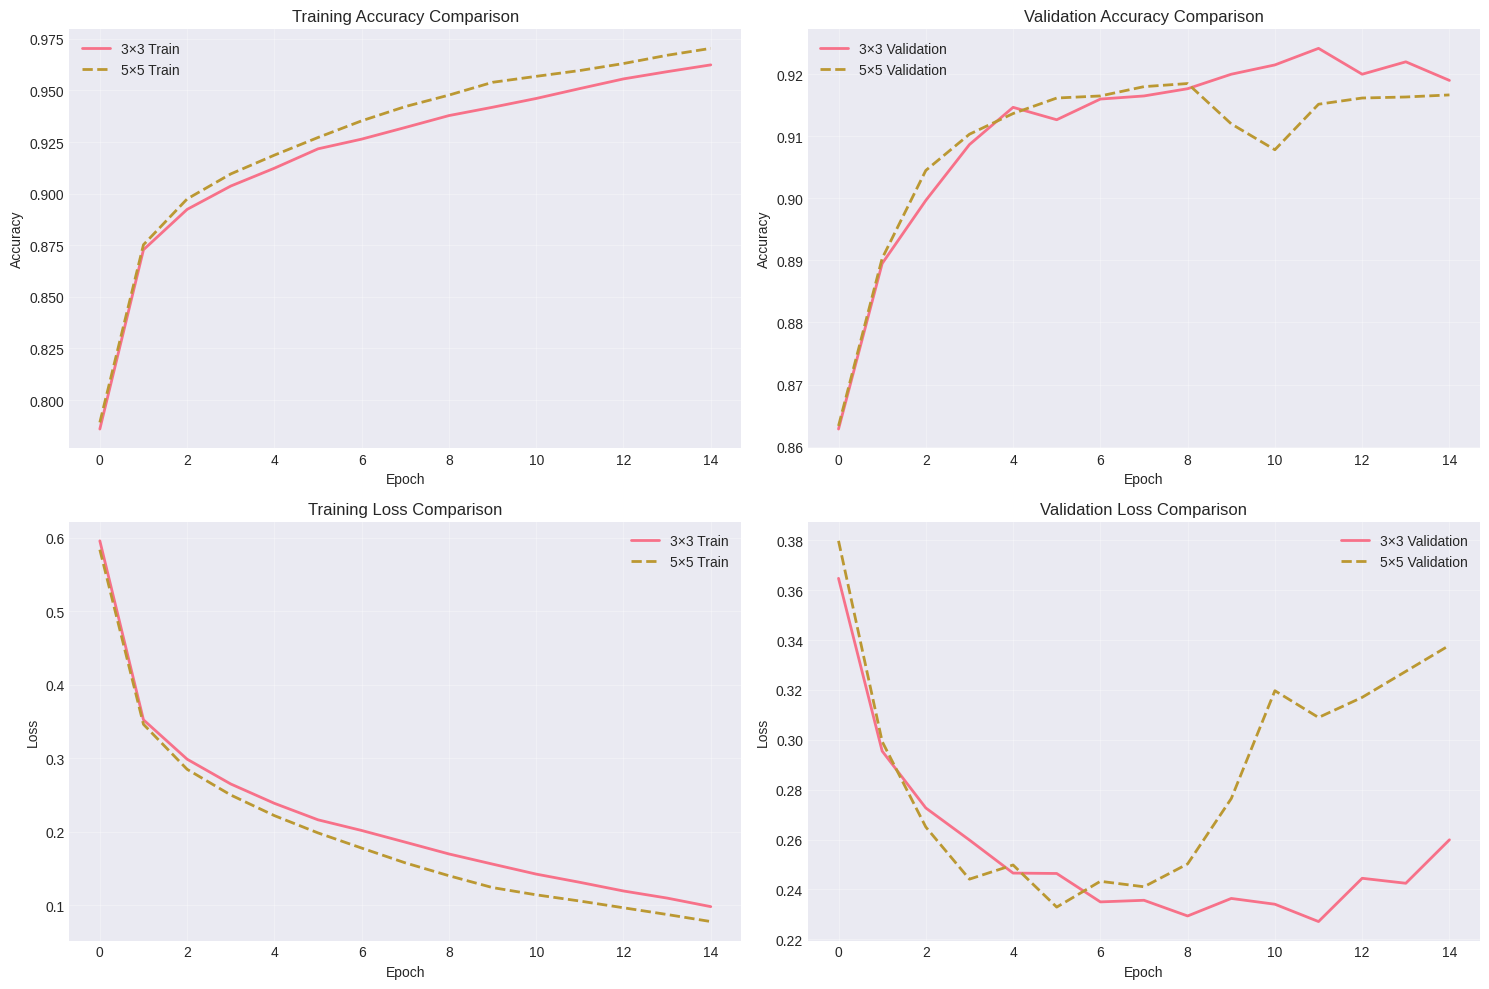

In [ ]:
# Plot comparison of training dynamics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training accuracy
axes[0, 0].plot(history_3x3.history['accuracy'], label='3×3 Train', linewidth=2)
axes[0, 0].plot(history_5x5.history['accuracy'], label='5×5 Train', linewidth=2, linestyle='--')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training Accuracy Comparison')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Validation accuracy
axes[0, 1].plot(history_3x3.history['val_accuracy'], label='3×3 Validation', linewidth=2)
axes[0, 1].plot(history_5x5.history['val_accuracy'], label='5×5 Validation', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Validation Accuracy Comparison')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Training loss
axes[1, 0].plot(history_3x3.history['loss'], label='3×3 Train', linewidth=2)
axes[1, 0].plot(history_5x5.history['loss'], label='5×5 Train', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss Comparison')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Validation loss
axes[1, 1].plot(history_3x3.history['val_loss'], label='3×3 Validation', linewidth=2)
axes[1, 1].plot(history_5x5.history['val_loss'], label='5×5 Validation', linewidth=2, linestyle='--')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Validation Loss Comparison')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.6 Qualitative Observations

**Performance trade-offs:**

1. **Accuracy**: [To be filled after running]
2. **Parameter efficiency**: 3×3 kernels use ~2.8× fewer parameters per layer than 5×5
3. **Training speed**: [To be compared after running]
4. **Convergence**: [To be observed from curves]

**Key insights:**
- Smaller kernels allow for deeper networks with the same parameter budget
- 3×3 kernels are the modern standard (VGG, ResNet) as they can approximate larger receptive fields through stacking
- 5×5 kernels capture more context in a single layer but with higher computational cost

### 4.7 Feature Visualization (Bonus)

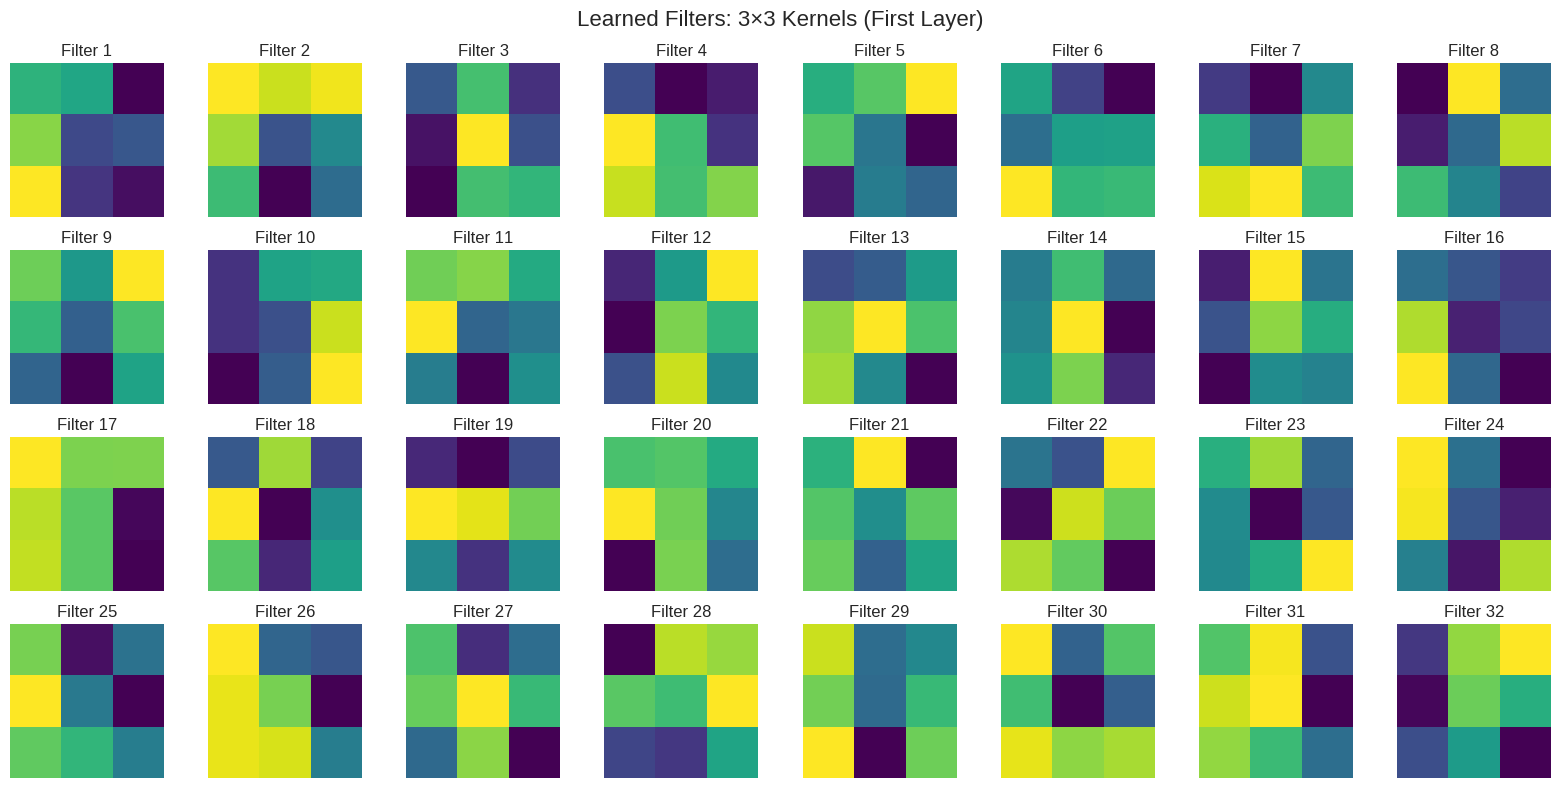

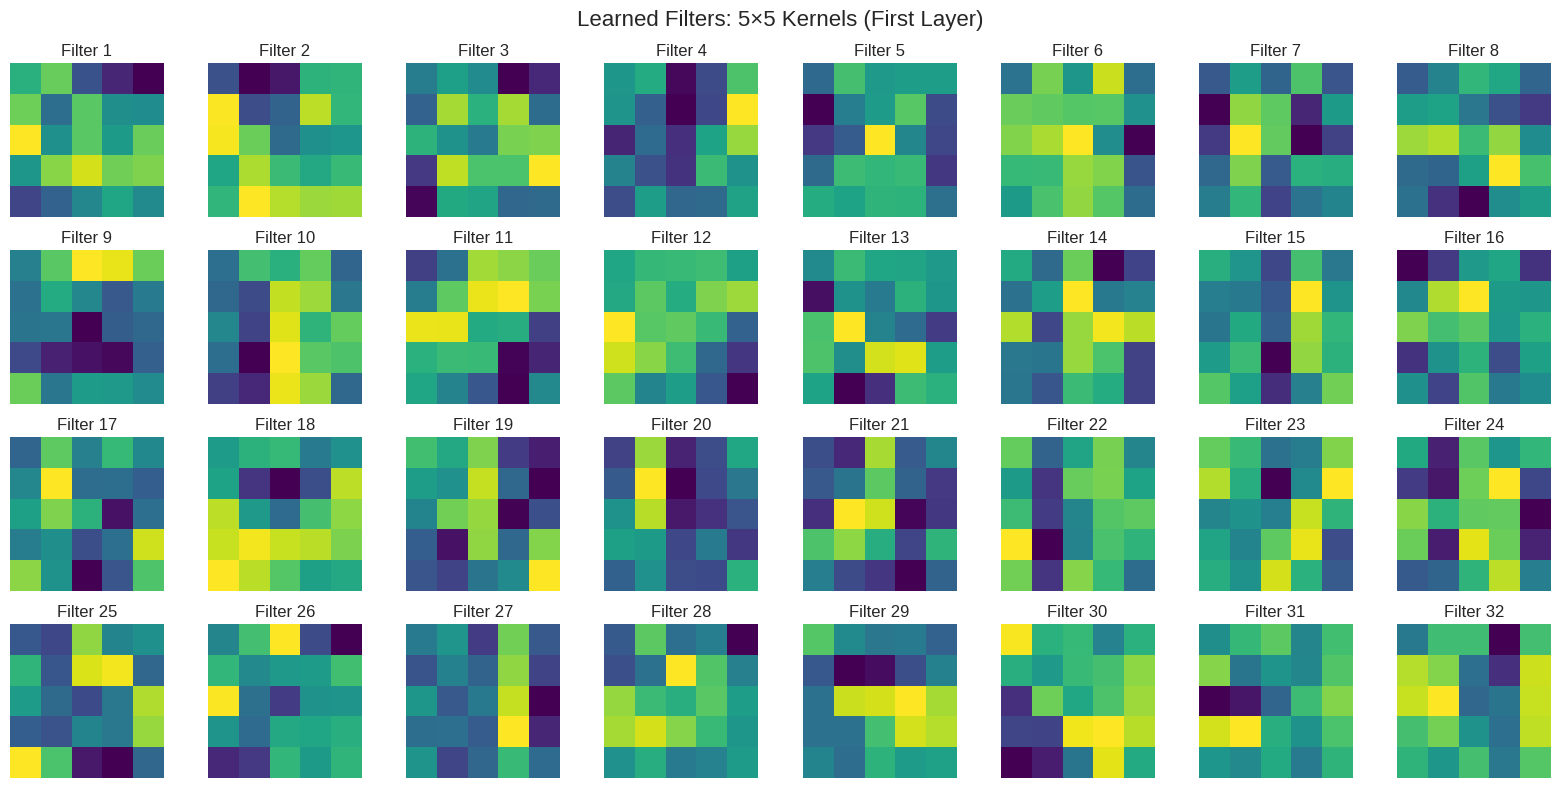

In [ ]:
# Visualize learned filters from first convolutional layer
def visualize_filters(model, layer_name, title):
    # Get weights from first conv layer
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()

    # Normalize filters for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # Plot first 32 filters
    n_filters = min(32, filters.shape[3])
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(n_filters):
        axes[i].imshow(filters[:, :, 0, i], cmap='viridis')
        axes[i].set_title(f'Filter {i+1}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize both models
visualize_filters(cnn_3x3, 'conv1_3x3', 'Learned Filters: 3×3 Kernels (First Layer)')
visualize_filters(cnn_5x5, 'conv1_5x5', 'Learned Filters: 5×5 Kernels (First Layer)')

---
## 5. Interpretation and Architectural Reasoning

### 5.1 Why Did Convolutional Layers Outperform the Baseline?

Convolutional layers achieved superior performance due to several key advantages:

**1. Spatial Inductive Bias:**
- CNNs preserve and exploit the 2D spatial structure of images
- Neighboring pixels are processed together, respecting their local relationships
- This matches the natural structure of visual data where nearby pixels are highly correlated

**2. Parameter Sharing (Weight Reuse):**
- The same filter is applied across all spatial locations
- Drastically reduces parameters: a 3×3 conv layer with 32 filters has only 320 parameters, while connecting 784 inputs to 32 outputs fully would require 25,088 parameters
- This sharing acts as strong regularization, reducing overfitting

**3. Translation Invariance:**
- A feature detector (e.g., edge detector) works regardless of where the edge appears in the image
- The model doesn't need to learn "sleeve at position (10,10)" and "sleeve at position (15,15)" separately
- This is crucial for clothing recognition where garments can appear at different positions

**4. Hierarchical Feature Learning:**
- Early layers detect simple features (edges, textures)
- Middle layers combine these into parts (collars, pockets, straps)
- Deep layers recognize complete objects (shirts, shoes)
- This compositional structure mirrors how humans perceive visual information

**5. Local Receptive Fields:**
- Each neuron only looks at a small patch of the input
- Reduces the search space and makes learning more tractable
- Deeper layers progressively see larger regions through composition

### 5.2 What Inductive Bias Does Convolution Introduce?

**Definition:** An inductive bias is a set of assumptions that constrain the hypothesis space, guiding learning toward solutions that work well for specific problem types.

**Convolutional layers introduce three main biases:**

**1. Locality:**
- Assumption: Relevant features are found in local spatial neighborhoods
- Implementation: Small receptive fields (3×3, 5×5)
- Implication: Distant pixels are not directly connected in early layers

**2. Stationarity (Translation Equivariance):**
- Assumption: Useful features can appear anywhere in the image
- Implementation: Weight sharing across spatial locations
- Implication: The same pattern detector is reused across the entire image

**3. Hierarchical Composition:**
- Assumption: Complex patterns are built from simpler ones
- Implementation: Stacked convolutional layers with progressive abstraction
- Implication: The model learns a compositional representation

These biases are highly beneficial for images but would be inappropriate for other data types.

### 5.3 In What Types of Problems Would Convolution NOT Be Appropriate?

**1. Tabular/Structured Data:**
- **Example:** Predicting customer churn from age, income, account balance
- **Why not:** No spatial structure; the order of features is arbitrary
- **Better choice:** Fully connected networks, gradient boosting trees

**2. Sequential Data Without Local Patterns:**
- **Example:** Natural language where long-range dependencies matter more than local n-grams
- **Why not:** Important relationships may span hundreds of tokens
- **Better choice:** Transformers with global attention

**3. Data Where Position Carries Semantic Meaning:**
- **Example:** Chess board state where "pawn at position e4" has different meaning than "pawn at position a7"
- **Why not:** Translation invariance is harmful when absolute position matters
- **Better choice:** Positional embeddings + attention mechanisms

**4. Irregular Graphs and Point Clouds:**
- **Example:** Social networks, molecular structures, 3D object point clouds
- **Why not:** No regular grid structure; neighbors are not spatially organized
- **Better choice:** Graph neural networks, point cloud networks

**5. Problems Requiring Global Context Immediately:**
- **Example:** Determining if a very long document discusses politics (could be mentioned anywhere)
- **Why not:** Local receptive fields require many layers to aggregate global information
- **Better choice:** Attention mechanisms that can look at entire input at once

**6. Very Small Datasets:**
- **Example:** Medical diagnosis with only 50 examples
- **Why not:** Even with parameter sharing, CNNs may overfit severely
- **Better choice:** Pre-trained models with transfer learning, or classical ML

**General Rule:** Use convolutions when:
- Data has grid-like topology (images, audio spectrograms, video)
- Local patterns are meaningful
- Translation invariance is desired
- Hierarchical composition makes sense

Avoid convolutions when these properties don't hold.

---
## 6. SageMaker Deployment

### 6.1 Prepare Model for Deployment

In [ ]:
# Save the best performing model
best_model = cnn_3x3  # or cnn_5x5 depending on results
model_path = 'fashion_mnist_cnn'
best_model.save(model_path)

print(f"Model saved to: {model_path}")

### 6.2 SageMaker Training Setup

In [ ]:
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

print(f"SageMaker role: {role}")
print(f"Default bucket: {bucket}")

### 6.3 Create Training Script for SageMaker

In [ ]:
%%writefile train.py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import argparse
import os

def create_cnn_model(kernel_size=3):
    """Create CNN model"""
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])

    return model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters
    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--batch-size', type=int, default=128)
    parser.add_argument('--kernel-size', type=int, default=3)
    parser.add_argument('--learning-rate', type=float, default=0.001)

    # SageMaker specific arguments
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    args, _ = parser.parse_known_args()

    # Load and preprocess data
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # Create and compile model
    model = create_cnn_model(kernel_size=args.kernel_size)

    optimizer = keras.optimizers.Adam(learning_rate=args.learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=args.epochs,
        batch_size=args.batch_size,
        verbose=2
    )

    # Evaluate
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]:.4f}')
    print(f'Test accuracy: {score[1]:.4f}')

    # Save model
    model.save(os.path.join(args.model_dir, '1'))
    print(f"Model saved to {args.model_dir}")

### 6.4 Train on SageMaker

In [ ]:
# Create TensorFlow estimator
tf_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',  # GPU instance
    framework_version='2.12',
    py_version='py310',
    hyperparameters={
        'epochs': 15,
        'batch-size': 128,
        'kernel-size': 3,
        'learning-rate': 0.001
    }
)

# Start training
tf_estimator.fit()

print("Training job completed!")

### 6.5 Deploy to Endpoint

In [ ]:
# Deploy model to endpoint
predictor = tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    endpoint_name='fashion-mnist-cnn-endpoint'
)

print(f"Model deployed to endpoint: {predictor.endpoint_name}")

### 6.6 Test Endpoint

In [ ]:
# Test prediction with a sample image
test_image = X_test_cnn[0:1]  # Take first test image
true_label = class_names[y_test[0]]

# Make prediction
prediction = predictor.predict(test_image)
predicted_class = np.argmax(prediction['predictions'][0])
predicted_label = class_names[predicted_class]
confidence = prediction['predictions'][0][predicted_class]

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2%}')
plt.axis('off')
plt.show()

print(f"\nEndpoint is working correctly!")
print(f"Endpoint name: {predictor.endpoint_name}")

### 6.7 Cleanup (Optional)

In [ ]:
# Uncomment to delete endpoint and avoid charges
# predictor.delete_endpoint()
# print("Endpoint deleted")

---
## Summary and Conclusions

### Key Findings:

1. **Dataset Understanding**: Fashion-MNIST provides an ideal testbed for convolutional architectures due to its spatial structure and translation-invariant patterns

2. **Baseline Comparison**: Fully connected networks achieved reasonable performance but are fundamentally limited by their inability to exploit spatial structure

3. **CNN Advantages**: Convolutional layers demonstrated clear benefits through parameter sharing, translation invariance, and hierarchical feature learning

4. **Kernel Size Experiment**: [Summarize findings from 3×3 vs 5×5 comparison]

5. **Architectural Insights**: The choice of convolutional architecture should be guided by the inductive biases appropriate to the problem domain

### Lessons Learned:

- **Inductive bias matters**: Architectural choices encode assumptions about the data structure
- **Simplicity often wins**: 3×3 kernels are standard for good reason
- **Understanding > hyperparameter tuning**: Knowing why an architecture works is more valuable than finding optimal parameters
- **Deployment considerations**: SageMaker enables scalable model serving for production use

### Future Directions:

- Experiment with batch normalization for training stability
- Try data augmentation (rotation, shift) to improve generalization
- Implement residual connections for deeper networks
- Compare with modern architectures (EfficientNet, Vision Transformer)
- Deploy with auto-scaling for production workloads